In [1]:
import os
import sys
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

module_dir = os.path.abspath('../src')  # Adjust path as needed
sys.path.append(module_dir)

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from functools import reduce
import numpy.testing as npt
from operator import itemgetter, attrgetter
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14
pd.options.display.float_format = '{:.2g}'.format

2024-11-14 16:43:09


In [2]:
from pynext.system_of_units import *

In [3]:
from pynext.Material import PhysicalMaterial
from pynext.PhysicalVolume import PhysicalVolume
from pynext.Shapes import Cylinder, CylinderShell, FlatPlate

In [4]:
from pynext.xetd import Xenon, CXe

In [5]:
from pynext.geometry import draw_cylinder, draw_2cylinder, draw_2cylynder_surface
from pynext.geometry import Cylinder as GCylinder
from pynext.geometry import vectors_spherical
from pynext.geometry import Ray, ray_intersection_with_cylinder
from pynext.geometry import generate_and_transport_gammas_lxe_shell
from pynext.geometry import generate_and_transport_gammas_lxe_endcaps
from pynext.histograms import h1d

In [6]:
from pynext.CylindricalVessel import  CVD
from pynext.CylindricalVessel import  CylindricalVessel
from pynext.Material import  cu12, cu03
from pynext.activity_functions import  activity_of_CV, print_activity_of_CV

In [7]:
from pynext.energy import gaussian, integrate_gaussian_from_x0
from pynext.energy import plot_gaussians, energy_window_eff, energy_window_fom

# Toy LXe Detector

- The goal of this excercize is to compute the irreducible background due to the Bi-214 activity in the copper vessel that host the liquid TPC of nEXO. 

- To this effect we need to know the dimensions of the nEXO vessel and TPC, as well as the activity of Bi-214 in the vessel. These data are available in the [nEXO CDR](https://https://arxiv.org/abs/1805.11142). 

- We also need to know the total (photoelectric) interaction cross section in LXe. These data are available from
[NIST](https://physics.nist.gov/cgi-bin/Xcom/xcom3_1) 

- The calculation itself is straight forward.
    - Compute the activity (self-shielded) of Bi-214 in the copper vessel.
    - Obtain the number of gammas with energies 2.448 MeV emitted by Bi-214 (1.5 %, see [here](https://www.nndc.bnl.gov/nudat3/decaysearchdirect.jsp?nuc=214Bi&unc=NDS)
    - Propagate these gammas to the fiducial region in nEXO (a central cylinder with a mass of 1 ton).
    - Weight the distance they travel by the attenuation factor $e^{-d/L_{att}}$, where $L_{att}$ can be computed from the NIST data.
    - Multiply by the photoelectric fraction.
- Notice that the 2.448 MeV gammas from Bi-214  interacting photoelectric in the detector constitute an irreducible background, since the mimic precisely the Qbb signal (which is at 2.458 keV, and cannot be separated with the energy resolution of 2-3 \% FWHM of nEXO). The problem, in fact, can be reversed, asking what is the maximum radioactive budget that the detector can tolerate given a target rate of background events in the ROI.
- This is just a simple (toy!) calculation, intended to illustrate the basic aspects of the game, all bb0nu experiments have sophisticated background models and hyper-tuned Monte Carlos to make a precise prediction of backgrounds. 
  


## Physics

In [8]:
def mu_vs_e(npdata):
    return npdata[:,0] * MeV, npdata[:,1] * (cm2/g)

In [9]:
def mu_vs_e_phot(npdata):
    return npdata[:,0] * MeV, npdata[:,1] * (cm2/g), npdata[:,2] * (cm2/g)

In [10]:
def get_murho(energy, mu_over_rho_phot, mu_over_rho_tot):
    def get_murho_at_energy():
        for i, e in enumerate(energy):
            if energy[i] == 2.5:
                break
        return mu_over_rho_phot[i], mu_over_rho_tot[i]
    return get_murho_at_energy()

In [14]:
xphot= np.loadtxt('cross_sections.csv', comments='#')

In [15]:
energy, mu_over_rho_phot, mu_over_rho_tot = mu_vs_e_phot(xphot)

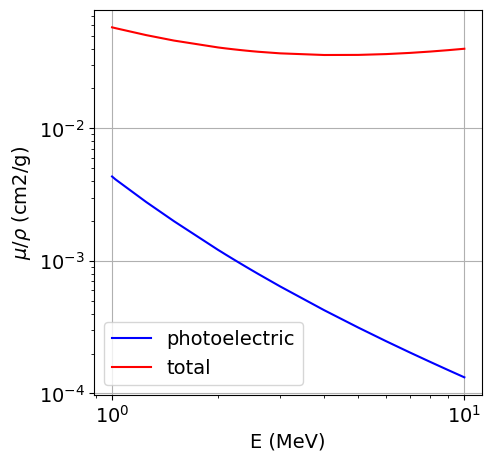

In [16]:
fig = plt.figure(figsize=(5,5))
plt.loglog(energy / MeV, mu_over_rho_phot/ (cm2/g),'b', label='photoelectric')
plt.loglog(energy / MeV, mu_over_rho_tot/(cm2/g),'r', label='total')
plt.grid(True)
plt.xlabel('E (MeV)')
plt.ylabel(r'$\mu/\rho$ (cm2/g)')
plt.legend()
#plt.text(0.005, 1000, r'photoelectric $\mu/\rho$ for xenon')
plt.show()

In [17]:
rholxe = 3 * g/cm3
murho_phot_2447, murho_tot_2447 = get_murho(energy, mu_over_rho_phot, mu_over_rho_tot)
xPheTot = murho_phot_2447/murho_tot_2447
muxe_2447 = murho_tot_2447 * rholxe
latt_2447 = 1/muxe_2447

In [18]:
print(f"mu/rho (tot) = {murho_tot_2447/(cm2/g)} cm2/g")
print(f"Photoelectric fraction = {xPheTot}")
print(f"Latt in LXe (2447 keV gammas) = {latt_2447/cm} cm")

mu/rho (tot) = 0.03819 cm2/g
Photoelectric fraction = 0.022183817753338567
Latt in LXe (2447 keV gammas) = 8.728288382648163 cm


## Dimensions
- The toy LXe detector that we will consider is an idealisation of nEXO. It consists of a radiopure copper vessel hosting a TPC. The dimensions are taken from nEXO CDR.


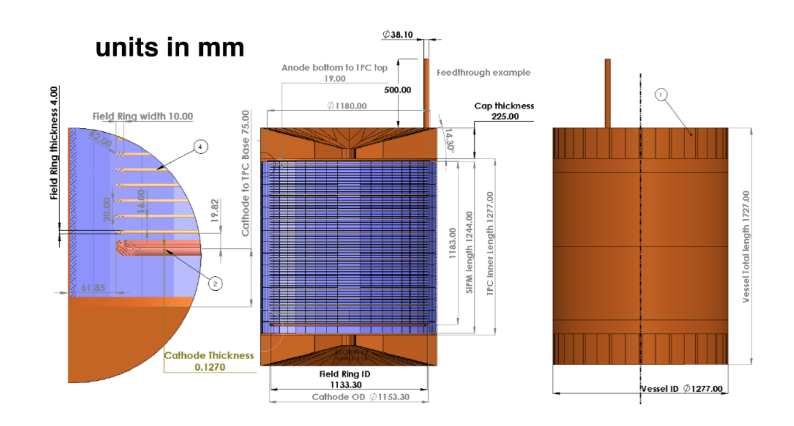

In [19]:
img = mpimg.imread('nexo.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

## Define the TPC

### Xenon

In [20]:
lxe = Xenon("lxe")
lxe


        material                                   = lxe
        density (rho)                              =       3 g/cm3
        mass attenuation coefficient (mu_over_rho) =   0.039 cm2/g
        attenuation coefficient (mu)               =    0.12 cm^-1
        attenuation length (Latt)                  =     8.5 cm
    

### Xenon Volume


In [21]:
cathode_OD = 1153 * mm
TPC_D = 1180 * mm
TPC_L = 1183 * mm
catode_lxe_buffer = 75 * mm
anode_lxe_buffer = 19 * mm
TPC_fid_L = TPC_L - catode_lxe_buffer - anode_lxe_buffer
TPC_fid_D = cathode_OD
t_lxe_buffer = (TPC_D - TPC_fid_D)/2

lxetd = CXe(lxe, R=TPC_D/2, L=TPC_L, Rb=t_lxe_buffer/2, Cb=catode_lxe_buffer, Ab=anode_lxe_buffer)
lxetd


        
        material                                   = lxe
        density (rho)                              =       3 g/cm3
        mass attenuation coefficient (mu_over_rho) =   0.039 cm2/g
        attenuation coefficient (mu)               =    0.12 cm^-1
        attenuation length (Latt)                  =     8.5 cm
    
        
        Fiducial Radius =   59.00 cm  xe Radius =   59.67 cm
        Fiducial Length =  118.30 cm  Xe Length =  127.70 cm
        
        Fiducial Volume =    1.29 m3 Xe Volume =    1.43 m3
        Fiducial mass = 3881.15 kg Xe mass = 4285.95 kg
        
        Radial buffer radius =    0.68 cm (E/P ~ 2)
        Cathode buffer thickness =    7.50 cm   (E/P~1)
        Anode buffer thickness =    1.90 cm
        
        Long buffer Volume =    0.03 m3
        Long buffer mass =   96.41 kg
        
        Cathode buffer Volume =    0.08 m3
        Cathode buffer mass =  251.72 kg
        
        Anode buffer Volume =    0.02 m3
        Anode bu

### Physics Volume
-Define a second LXe volume, the shielded volume in which one carries on physics (1 ton fiducial)


In [22]:

lxe_phys_radius = 375 * mm
lxe_phys_diameter = 2 * lxe_phys_radius
lxe_phys_length = 750 * mm

lxes = CXe(lxe, R=lxe_phys_radius, L=lxe_phys_length, Rb=0.01*mm, Cb=0.01*mm, Ab=0.01*mm)

In [23]:

lxes


        
        material                                   = lxe
        density (rho)                              =       3 g/cm3
        mass attenuation coefficient (mu_over_rho) =   0.039 cm2/g
        attenuation coefficient (mu)               =    0.12 cm^-1
        attenuation length (Latt)                  =     8.5 cm
    
        
        Fiducial Radius =   37.50 cm  xe Radius =   37.50 cm
        Fiducial Length =   75.00 cm  Xe Length =   75.00 cm
        
        Fiducial Volume =    0.33 m3 Xe Volume =    0.33 m3
        Fiducial mass =  994.02 kg Xe mass =  994.10 kg
        
        Radial buffer radius =    0.00 cm (E/P ~ 2)
        Cathode buffer thickness =    0.00 cm   (E/P~1)
        Anode buffer thickness =    0.00 cm
        
        Long buffer Volume =    0.00 m3
        Long buffer mass =    0.05 kg
        
        Cathode buffer Volume =    0.00 m3
        Cathode buffer mass =    0.01 kg
        
        Anode buffer Volume =    0.00 m3
        Anode bu

In [24]:
L_shield = (TPC_L - lxe_phys_length)/2
t_shield = (TPC_D - lxe_phys_diameter)/2
print(f"length of the LXe shield between vessel and physics volume = {L_shield/mm}")
print(f"thickness of the LXe shield between vessel and physics volume = {t_shield/mm}")

length of the LXe shield between vessel and physics volume = 216.5
thickness of the LXe shield between vessel and physics volume = 215.0


### Fraction of gammas that interact in Shielded volume
- We can make a first, rough estimation, computing the fraction of gammas travelling along the longitudinal axis that interact in the physics volume. We can also compute the fraction of gammas travelling along the radial axis that interact in the physics volume.
- Notice, however, that this number overestimates grossly the fraction of interactions in the physics volume, since gammas are emitted in all directions, and a big fraction of them never make it to the physics volume. 

In [25]:
print(f" Fraction of gammas along longitudinal axis that interact in Shielded volume ={lxetd.xe.material.transmittance_at_qbb(L_shield)}") 

 Fraction of gammas along longitudinal axis that interact in Shielded volume =0.07941643041164195


In [26]:
print(f" Fraction of gammas along radial axis that interact in Shielded volume ={lxetd.xe.material.transmittance_at_qbb(t_shield)}") 

 Fraction of gammas along radial axis that interact in Shielded volume =0.08082249085677992


### Copper vessel

In [27]:
vessel_length   = 1727 * mm
vessel_diameter = 1277 * mm
vessel_radius = vessel_diameter/2
vessel_head_thickness = 225 * mm
vessel_body_thickness = (vessel_diameter - TPC_D)/2

print(f"LXe copper Vessel: Length = {vessel_length/mm} mm, diameter = {vessel_diameter/mm} mm")
print(f"LXe copper Vessel: thickness body = {vessel_body_thickness/mm} mm, thickness head = {vessel_head_thickness/mm} mm")

LXe copper Vessel: Length = 1727.0 mm, diameter = 1277.0 mm
LXe copper Vessel: thickness body = 48.5 mm, thickness head = 225.0 mm


In [28]:
culxe = CVD(name    ='LXeCuVessel',
            R       = vessel_radius,
            th_body = vessel_body_thickness,
            L       = vessel_length,
            th_head = vessel_head_thickness)
culxe

CVD(name='LXeCuVessel', R=638.5, th_body=48.5, L=1727.0, th_head=225.0)

### We create a cylindrical vessel filled up with cu03, a type of radiopure copper.
- cu03 radiopurity corresponds to 3 muBq/kg, essentially in the limit of waht can be achieved for copper.

In [29]:
pvlxe = CylindricalVessel(name='LXeVessel', material=cu03, cvd=culxe)
pvlxe


        Cylindrical Vessel:

        ----------------
        name      = LXeCuVessel
        material  = CuBest

        specific activity of material:
        Bi-214    = 3.00e-03 mBq/kg
        Tl-208    = 1.40e-03 mBq/kg

        body:
        R              =  638.50 mm
        body thickness =   48.50 mm
        head thickness =  225.00 mm
        length         = 1727.00 mm
        surface        = 6.93e+06 mm2
        volume         = 3.49e+08 mm3
        mass           = 3125.16 kg
        activity Bi-214 =    9.38 mBq, self-shielded =   1.55 mBq
        activity Tl-208 =    4.38 mBq, self-shielded =   0.72 mBq
        transmittance   = 1.84e-01

        heads:
        thickness =  225.00 mm
        surface   = 2.56e+06 mm2
        volume    = 5.76e+08 mm3
        mass      = 5164.07 kg
        activity Bi-214 =    7.75 mBq, self-shielded =   0.31 mBq
        activity Tl-208 =    3.61 mBq, self-shielded =   0.15 mBq
        transmittance   = 3.85e-04

        

### Activity of Cu vessel
- Most of the activity is self-shielded, so that the remaining activity is a small fraction, larger for Bi-214 than for Tl-208 and larger in the radial direction than in the axial direction where self-shield is larger.
- It follows that the dominant effect for radioactivity will be Bi-214 gammas shot from the body of the vessel.
- Notice also that Bi-214 gammas are ~10 keV of Xe-137 Qbb, and thus with the resolution of LXe cannot be separated at all using resolution

In [30]:
cs_activity = activity_of_CV('activity of LXe PV (self-shielded)', pvlxe)
print_activity_of_CV(cs_activity, unit='mBq')


    activity 		 activity of LXe PV (self-shielded)
    body  (Bi-214) 	    1.55 mBq
    head  (Bi-214) 	    0.31 mBq
    total (Bi-214) 	    1.86 mBq
    body  (Tl-208) 	    0.72 mBq
    head  (Tl-208) 	    0.15 mBq
    total (Tl-208) 	    0.87 mBq
    


In [31]:
cs_body_activity_bi214_Bq = cs_activity.body_bi214/Bq
cs_head_activity_bi214_Bq = cs_activity.head_bi214/Bq

## Generation and transport in LXe toy detector
- Our next goal is to estimate the fraction of gammas of 2.5 MeV (e.g, Bi-214) emitted from the copper vessel that will make it into the physics volume. This gammas represent an irreducible background, since they cannot be separated from signal (they produce a photolectric interaction with the same energy than the Qbb decay)
- This is simply an acceptance calculation. We will do it defining a volume (cshell) that represents the copper vessel and a second volume (cphys) that represents the LXe volume in which we want to do physics. We then shoot uniformly gammas from chsell in an angle of 2pi (since the activity that we have computed is already shielded, and includes those gammas that are shot backwards) and compute how many of them reach cphys.
- We use GGylinder, which represents a Geometrical-Cylinder (e.g, in space). All dimensions assumed to be in mm
- Notice that the dimensions of the shell cylinder correspond to the dimensions of the TPC, not to the cupper vessel, since we have already computed the attenuation of the copper.

In [32]:
cshell =GCylinder(TPC_D/2, zmin = 0, zmax = TPC_L)
cshell

Cylinder(r=590.0, zmin=0, zmax=1183.0)

In [33]:
zmin = (TPC_L - lxe_phys_length) / 2
zmax = zmin + lxe_phys_length
cphys =GCylinder(lxe_phys_radius, zmin, zmax)
cphys

Cylinder(r=375.0, zmin=216.5, zmax=966.5)

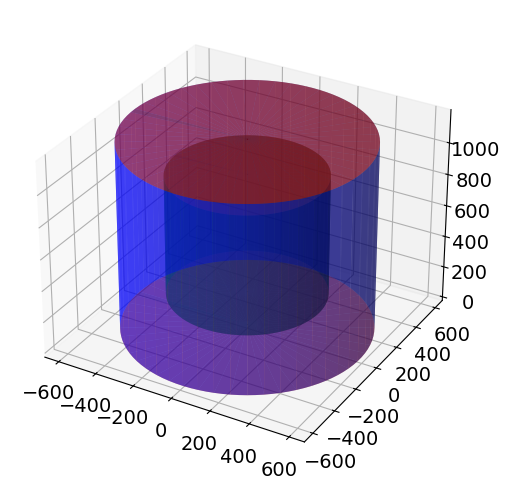

In [34]:
draw_2cylinder(cshell, cphys, alpha=0.5, figsize=(6,6))

#### Transport in the Barrel

c1 =Cylinder(r=590.0, zmin=0, zmax=1183.0)
c2 =Cylinder(r=375.0, zmin=216.5, zmax=966.5)


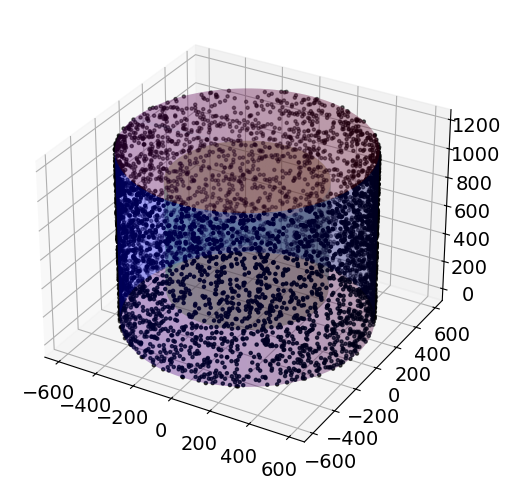

In [35]:
WF, DST = generate_and_transport_gammas_lxe_shell(cshell, cphys, 
                                       nphotons=5000, ndx= 100, 
                                       solidAngle="half",
                                       verbose=1, drawRays=False, scale=100)

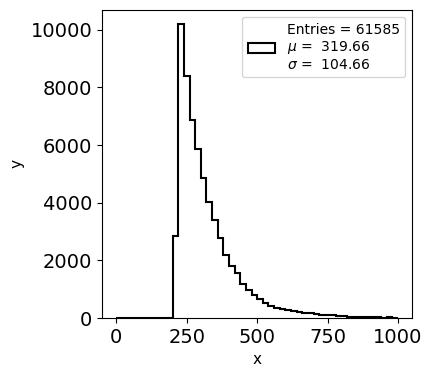

In [36]:
n, b, mu, std = h1d(DST, 50, (0, 1000), figsize=(4,4)) 

In [37]:
dx_barrel = mu
print(f"average distance travelled by interacting gammas = {dx_barrel} mm")

average distance travelled by interacting gammas = 319.6603796854101 mm


In [38]:
print(f"average attenuation, exponential law = {np.exp(-dx_barrel/latt_2447/mm)}")

average attenuation, exponential law = 0.025672138760585814


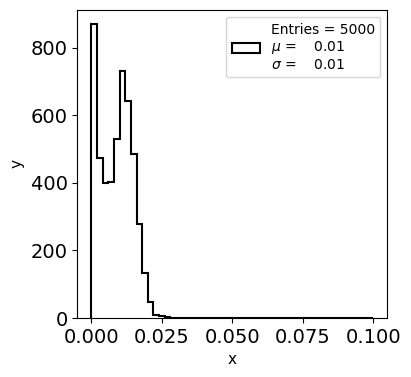

In [39]:
n, b, mu, std = h1d(WF, 50, (0, 0.1), figsize=(4,4)) 

In [40]:
w_barrel = mu
print(f"mean weight in barrel = {w_barrel:7.3g}")

mean weight in barrel = 0.00878


#### Transport end-caps

c1 =Cylinder(r=590.0, zmin=0, zmax=1183.0)
c2 =Cylinder(r=375.0, zmin=216.5, zmax=966.5)


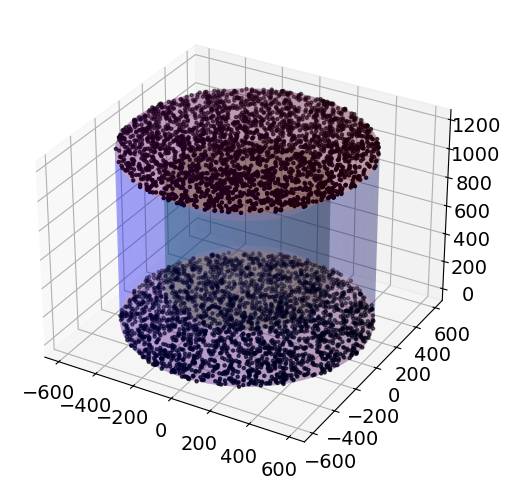

In [41]:
WF, DST = generate_and_transport_gammas_lxe_endcaps(cshell, cphys, 
                                       nphotons=5000, ndx= 100, 
                                       solidAngle="half",
                                       verbose=1, drawRays=False, scale=100)

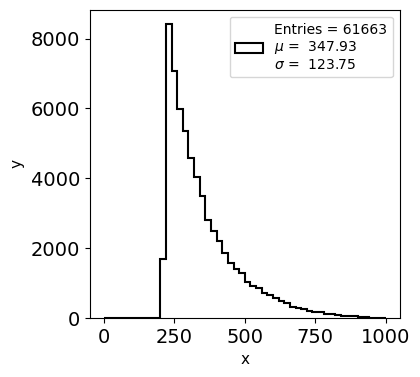

In [42]:
n, b, mu, std = h1d(DST, 50, (0, 1000), figsize=(4,4)) 

In [43]:
dx_ecap = mu
print(f"average distance travelled by interacting gammas = {dx_ecap} mm")

average distance travelled by interacting gammas = 347.93125157329837 mm


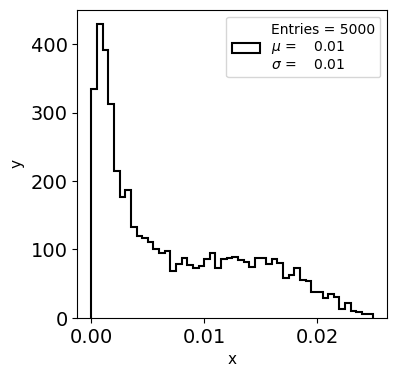

In [44]:
n, b, mu, std = h1d(WF, 50, (0, 0.025), figsize=(4,4)) 

In [45]:
w_ecap = mu
print(f"mean weight in end-caps = {w_ecap:7.2g}")

mean weight in end-caps =  0.0075


- The mean weight in the case of endcaps is even smaller (0.4%) given the longer attenuation. 

## Background of Bi-214 due to copper vessel. 

$$ R_{\gamma(2448 keV)}^{{}^{214}Bi} = A^{{}^{214}Bi} {\rm [Bq]} \times BR^{{}^{214}Bi}_{\gamma(2448 keV)} = 1.55 \cdot 10^{-3} {\rm [cts/sec]} \times 1.5 \cdot 10^{-2}$$

$$ N_{\gamma(2448 keV)}^{{}^{214}Bi} {\rm ~1 year} = R_{\gamma(2448 keV)}^{{}^{214}Bi} \times 3.1 \cdot 10^7 $$

$$ I_{\gamma(2448 keV)}^{{}^{214}Bi} {\rm ~ year/ROI/ton} = N_{\gamma(2448 keV)}^{{}^{214}Bi} \times f_{\gamma(2448 keV)}^{ROI} $$

$$ Phot_{\gamma(2448 keV)}^{{}^{214}Bi} {\rm ~ year/ROI/ton} = I_{\gamma(2448 keV)}^{{}^{214}Bi} \times 
\frac{\sigma_{phot}}{\sigma_{total}}(2448 keV) $$

### Bi-214 gamma (2448 keV)


In [46]:
brg = 1.5e-2           # BR of 2448 keV gamma
print(f"BR of 2448 keV gamma= {brg}")
print(f"Ratio of photoelectric to total cross section = {xPheTot}")

BR of 2448 keV gamma= 0.015
Ratio of photoelectric to total cross section = 0.022183817753338567


### Backgrounds in the Body

In [47]:
rg = cs_body_activity_bi214_Bq * brg
ng = rg * year/second
ig = ng * w_barrel
pg = ig * xPheTot
print(f"rate of gammas of 2448 keV emitted by copper (self-shielded) = {rg}")
print(f"number of gammas of 2448 keV emitted by copper (one year) = {ng}")
print(f"number of gammas of 2448 keV interacting in fiducial volume = {ig}")
print(f"number of gammas of 2448 keV making a photoelectric in fiducial volume = {pg}")

rate of gammas of 2448 keV emitted by copper (self-shielded) = 2.3212550046951485e-05
number of gammas of 2448 keV emitted by copper (one year) = 732.030978280662
number of gammas of 2448 keV interacting in fiducial volume = 6.424508783163066
number of gammas of 2448 keV making a photoelectric in fiducial volume = 0.1425201320004124


### Background due to end-caps

In [48]:
rg = cs_head_activity_bi214_Bq * brg
ng = rg * year/second
ig = ng * w_ecap
pg = ig * xPheTot
print(f"rate of gammas of 2448 keV emitted by copper (self-shielded) = {rg}")
print(f"number of gammas of 2448 keV emitted by copper (one year) = {ng}")
print(f"number of gammas of 2448 keV interacting in fiducial volume = {ig}")
print(f"number of gammas of 2448 keV making a photoelectric in fiducial volume = {pg}")

rate of gammas of 2448 keV emitted by copper (self-shielded) = 4.7033072433917735e-06
number of gammas of 2448 keV emitted by copper (one year) = 148.32349722760296
number of gammas of 2448 keV interacting in fiducial volume = 1.1060478380448904
number of gammas of 2448 keV making a photoelectric in fiducial volume = 0.02453636366566198


## Energy resolution in LXe

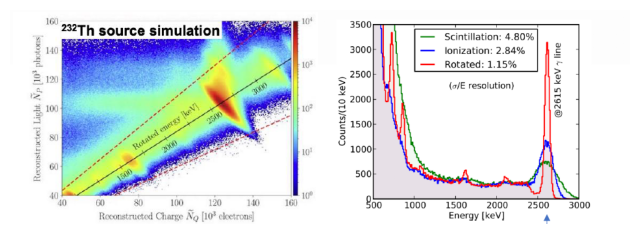

In [49]:
plt.figure(figsize=(8, 4))
img = mpimg.imread('scintioniexo.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [50]:
eth = 2615
sigma_th = 0.015
FWHM_th = sigma_th * 2.3
eqbb = 2457
FWHM_qbb = FWHM_th * np.sqrt(eth/eqbb)
print(f"EXO: FWHM at Qbb = {FWHM_qbb} %")

EXO: FWHM at Qbb = 0.03559199759834073 %


In [51]:
# LXe
mean1 = 2447
mean2 = 2457
sigma_x = 0.035/2.3  #3.5 % FWHM
sigma1 = mean1 * sigma_x
sigma2 = mean2 * sigma_x
print(f"sigma resolution around Qbb peak  = {sigma1} keV")

sigma resolution around Qbb peak  = 37.23695652173914 keV


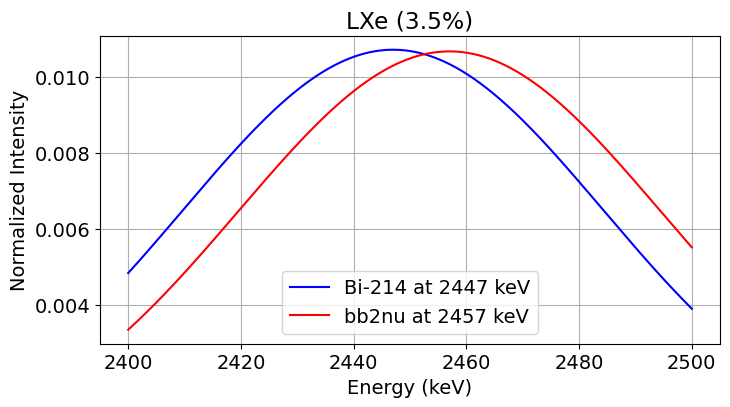

In [52]:
plot_gaussians(mean1, mean2, sigma1, sigma2, "LXe (3.5%)")

In [53]:
#  NEXO expects 1 % sigm
eth = 2615
sigma_th = 0.01
FWHM_th = sigma_th * 2.3
eqbb = 2457
FWHM_qbb = FWHM_th * np.sqrt(eth/eqbb)
print(f"nEXO (best): FWHM at Qbb = {FWHM_qbb} %")
mean1 = 2447
mean2 = 2457
sigma_x = FWHM_qbb/2.3  #3.5 % FWHM
sigma1 = mean1 * sigma_x
sigma2 = mean2 * sigma_x
print(f"sigma resolution around Qbb peak  = {sigma1} keV")

nEXO (best): FWHM at Qbb = 0.023727998398893824 %
sigma resolution around Qbb peak  = 25.244526992214432 keV


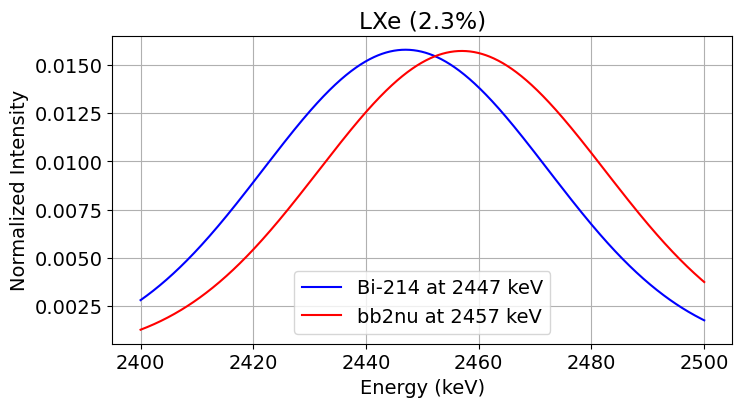

In [54]:
plot_gaussians(mean1, mean2, sigma1, sigma2, "LXe (2.3%)")

### Energy resolution
- Same separation due to energy resolution would be possible, but at very large cost in efficiency and does not seem needed for this level of background.

## Signal efficiency:
- The initial mass of the TPC is 4 tons and the physics mass is 1 ton: the efficiency of shielding is 20 \%